Part 1: Principal Component Analysis (PCA)
step 1.1

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Wine dataset
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None
)
df_wine.columns = [
    'Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
    'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
    'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]

# Split features and labels
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

# Standardize features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


step 1.2

In [13]:
import numpy as np

# Covariance matrix
cov_mat = np.cov(X_train_std.T)

# Eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Sort eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Projection matrix: top 2 principal components
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

# Transform training data
X_train_pca = X_train_std.dot(w)


Step 1.3

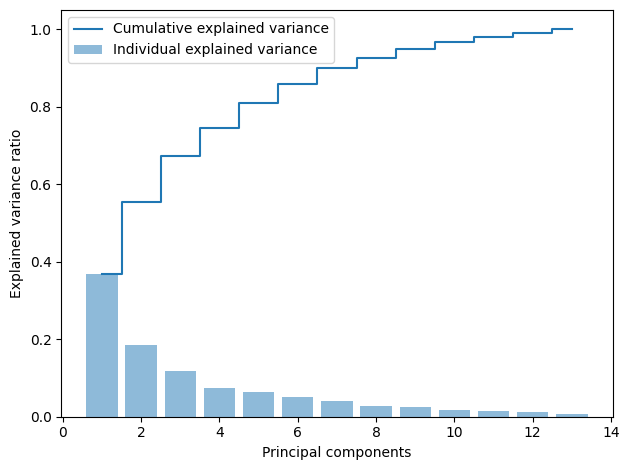

In [14]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Step 1.4

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca_sk = pca.fit_transform(X_train_std)
X_test_pca_sk = pca.transform(X_test_std)


step 1.5

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/tmp/ipython-input-2001554022.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.6,
/tmp/ipython-input-2001554022.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], al

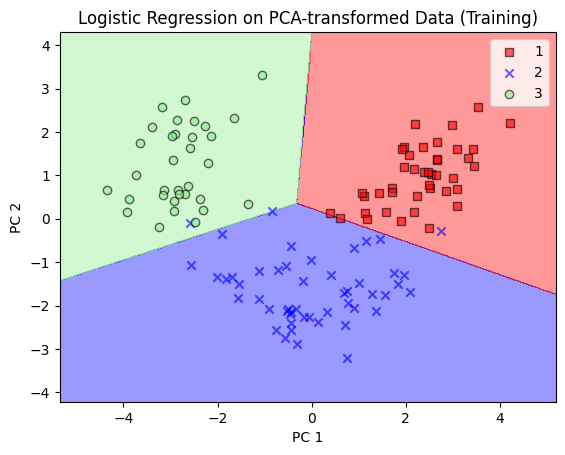

Test Accuracy: 0.926


In [15]:
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

# Logistic Regression
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_pca_sk, y_train)

# Plot decision regions
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.6,
                    c=cmap(idx), edgecolor='black', marker=markers[idx], label=cl)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc='best')

plot_decision_regions(X_train_pca_sk, y_train, classifier=lr)
plt.title('Logistic Regression on PCA-transformed Data (Training)')
plt.show()

# Test accuracy
print('Test Accuracy: %.3f' % lr.score(X_test_pca_sk, y_test))


Part 2: Linear Discriminant Analysis (LDA)  step 2.1


In [16]:
# Mean vectors per class
mean_vecs = [np.mean(X_train_std[y_train == label], axis=0) for label in np.unique(y_train)]
d = X.shape[1]  # features

# Within-class scatter
S_W = np.zeros((d, d))
for label, mv in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

# Between-class scatter
mean_overall = np.mean(X_train_std, axis=0)
S_B = np.zeros((d, d))
for i, mv in enumerate(mean_vecs):
    n = X_train[y_train == i+1].shape[0]
    mv = mv.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mv - mean_overall).dot((mv - mean_overall).T)


step 2.2

In [17]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = sorted([(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))],
                     key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
X_train_lda = X_train_std.dot(w)


step 2.3

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda_sk = lda.fit_transform(X_train_std, y_train)
X_test_lda_sk = lda.transform(X_test_std)


step 2.4

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/tmp/ipython-input-2001554022.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.6,
/tmp/ipython-input-2001554022.py:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], al

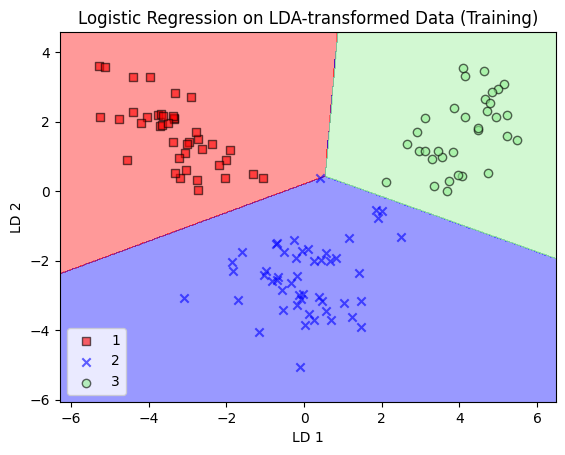

Test Accuracy: 1.000


In [19]:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_lda_sk, y_train)

plot_decision_regions(X_train_lda_sk, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.title('Logistic Regression on LDA-transformed Data (Training)')
plt.show()

print('Test Accuracy: %.3f' % lr.score(X_test_lda_sk, y_test))


Part 3: Kernel PCA (KPCA)
Step 3.1

In [22]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF Kernel PCA implementation.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Input data.
    gamma : float
        Tuning parameter of the RBF kernel.
    n_components : int
        Number of principal components to return.

    Returns
    -------
    X_pc : ndarray, shape (n_samples, n_components)
        Projected dataset onto top principal components.
    """
    # Step 1: Compute pairwise squared Euclidean distances
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)

    # Step 2: Compute the symmetric RBF kernel matrix
    K = np.exp(-gamma * mat_sq_dists)

    # Step 3: Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Step 4: Eigen-decomposition of the centered kernel matrix
    eigvals, eigvecs = eigh(K_centered)

    # Step 5: Collect the top k eigenvectors (largest eigenvalues)
    X_pc = np.column_stack([eigvecs[:, -i] for i in range(1, n_components + 1)])

    return X_pc



step 3.2

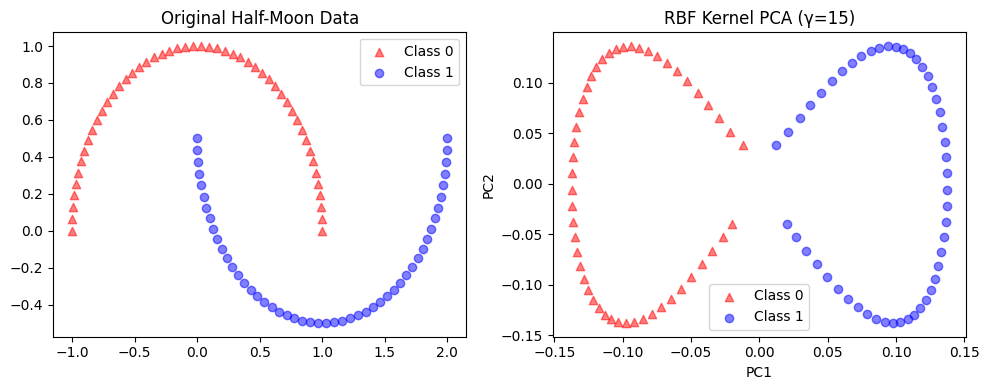

In [23]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate half-moon dataset
X, y = make_moons(n_samples=100, random_state=123)

# Apply RBF Kernel PCA
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

# Visualize original and transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Original data
ax1.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5, label='Class 0')
ax1.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5, label='Class 1')
ax1.set_title('Original Half-Moon Data')
ax1.legend()

# RBF Kernel PCA transformed data
ax2.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5, label='Class 0')
ax2.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5, label='Class 1')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('RBF Kernel PCA (γ=15)')
ax2.legend()

plt.tight_layout()
plt.show()


step 3.3

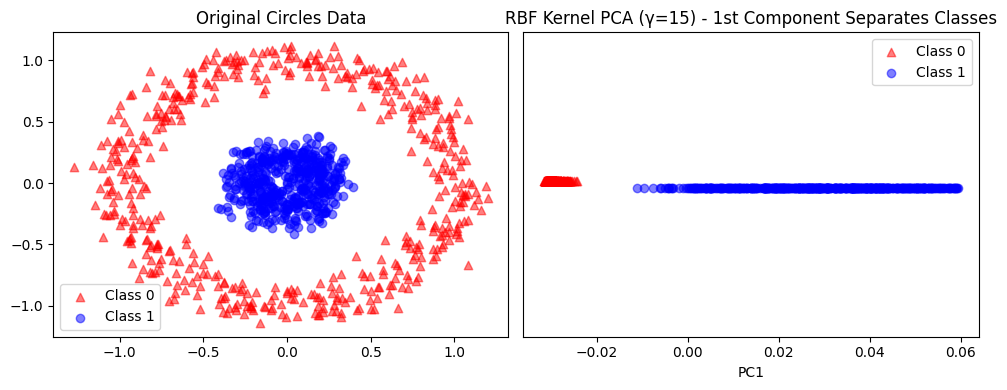

In [24]:
from sklearn.datasets import make_circles

# Generate circles dataset
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

# Apply RBF Kernel PCA
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

# Visualize original and transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Original circles data
ax1.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5, label='Class 0')
ax1.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5, label='Class 1')
ax1.set_title('Original Circles Data')
ax1.legend()

# RBF Kernel PCA transformed data
# Add slight y-jitter for visualization
ax2.scatter(X_kpca[y==0, 0], np.zeros(X_kpca[y==0, 0].shape) + 0.02, color='red', marker='^', alpha=0.5, label='Class 0')
ax2.scatter(X_kpca[y==1, 0], np.zeros(X_kpca[y==1, 0].shape) - 0.02, color='blue', marker='o', alpha=0.5, label='Class 1')
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')
ax2.set_title('RBF Kernel PCA (γ=15) - 1st Component Separates Classes')
ax2.legend()

plt.tight_layout()
plt.show()


step 3.4

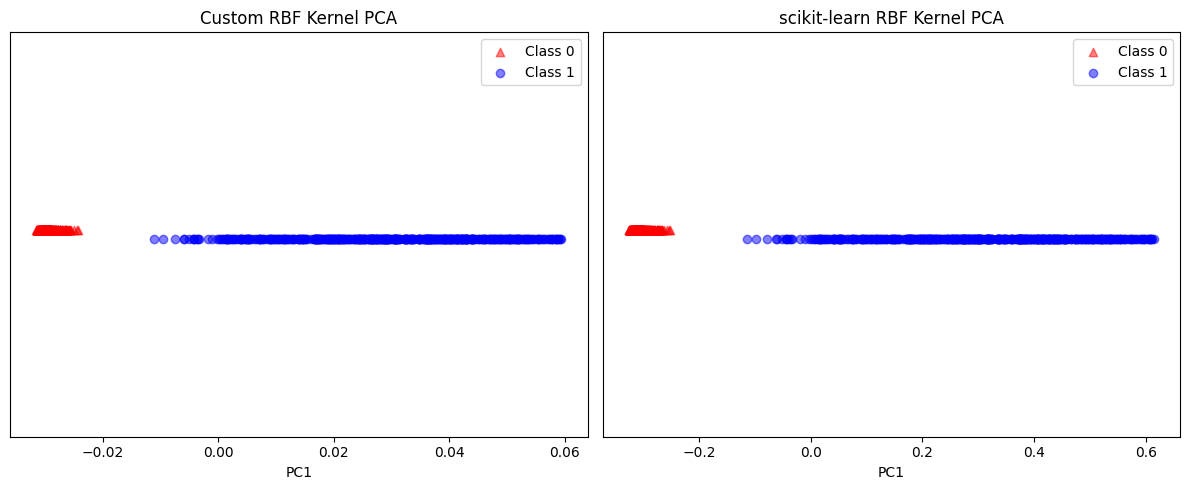

In [25]:
from sklearn.decomposition import KernelPCA

# Apply scikit-learn's Kernel PCA
kpca_sk = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca_sk = kpca_sk.fit_transform(X)  # using the last circles dataset

# Compare custom RBF KPCA vs. scikit-learn KPCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Custom RBF KPCA
ax1.scatter(X_kpca[y==0, 0], np.zeros(X_kpca[y==0, 0].shape) + 0.02, color='red', marker='^', alpha=0.5, label='Class 0')
ax1.scatter(X_kpca[y==1, 0], np.zeros(X_kpca[y==1, 0].shape) - 0.02, color='blue', marker='o', alpha=0.5, label='Class 1')
ax1.set_ylim([-1, 1])
ax1.set_yticks([])
ax1.set_xlabel('PC1')
ax1.set_title('Custom RBF Kernel PCA')
ax1.legend()

# scikit-learn Kernel PCA
ax2.scatter(X_kpca_sk[y==0, 0], np.zeros(X_kpca_sk[y==0, 0].shape) + 0.02, color='red', marker='^', alpha=0.5, label='Class 0')
ax2.scatter(X_kpca_sk[y==1, 0], np.zeros(X_kpca_sk[y==1, 0].shape) - 0.02, color='blue', marker='o', alpha=0.5, label='Class 1')
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')
ax2.set_title('scikit-learn RBF Kernel PCA')
ax2.legend()

plt.tight_layout()
plt.show()
